In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('transformed_data.csv', index_col='id', parse_dates=['date'])
df.head()

,Unnamed: 0,date,party,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8
id,,,,,,,,,,,,
DE-0190001007,0,2017-10-24,DIE LINKE,0.000540,0.072428,0.000540,0.000540,0.723960,0.182041,0.018873,0.000540,0.000540
DE-0190001008,1,2017-10-24,CDU/CSU,0.000505,0.000505,0.029021,0.000505,0.967441,0.000505,0.000505,0.000506,0.000505
DE-0190001010,2,2017-10-24,BÜNDNIS 90/DIE GRÜNEN,0.000520,0.000519,0.028013,0.000519,0.968350,0.000520,0.000520,0.000519,0.000519
DE-0190002005,3,2017-11-21,CDU/CSU,0.000678,0.069938,0.000678,0.000678,0.925317,0.000678,0.000678,0.000678,0.000678
DE-0190002015,4,2017-11-21,AfD,0.148448,0.775312,0.000473,0.000473,0.000473,0.073402,0.000473,0.000473,0.000473


In [3]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.sort_values(by='date', inplace=True)

## Summary statistics

In [4]:
df['party'].value_counts()

CDU/CSU                  2101
SPD                      1547
AfD                      1285
BÜNDNIS 90/DIE GRÜNEN    1188
FDP                      1186
DIE LINKE                1163
Name: party, dtype: int64

In [5]:
df[['date', 'party']].groupby('party')['date'].nunique()

party
AfD                      198
BÜNDNIS 90/DIE GRÜNEN    193
CDU/CSU                  203
DIE LINKE                190
FDP                      189
SPD                      195
Name: date, dtype: int64

In [6]:
df['date'].nunique()

207

## Topics

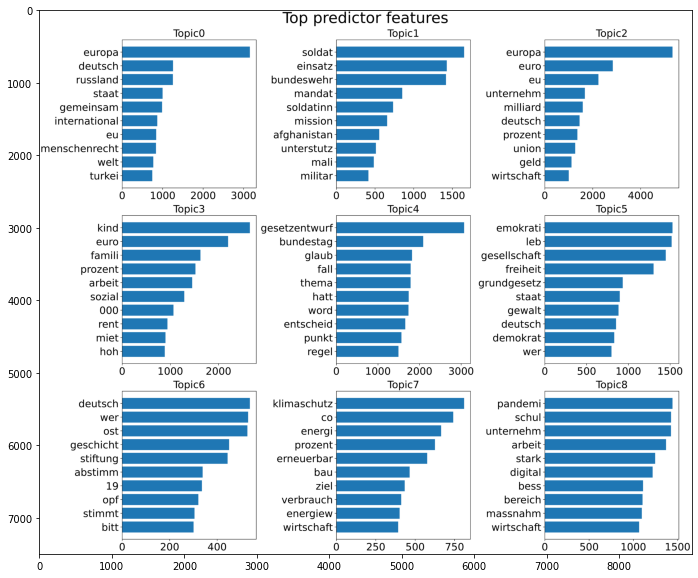

In [7]:
from pdf2image import convert_from_path
img = convert_from_path('topics_words.pdf', 500)[0]
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(img)

In [8]:
columns_mapper = {
    'Topic0': 'International',
    'Topic1': 'Military',
    'Topic2': 'EU/Economy',
    'Topic3': 'Social',
    'Topic4': 'Decisions/Law',
    'Topic5': 'Democracy/Freedom',
    'Topic6': 'German History',
    'Topic7': 'Ecology',
    'Topic8': 'Health/Pandemic',
}

In [9]:
df.rename(columns=columns_mapper, inplace=True)

In [10]:
df.describe()

,International,Military,EU/Economy,Social,Decisions/Law,Democracy/Freedom,German History,Ecology,Health/Pandemic
count,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000
mean,0.087238,0.052928,0.100198,0.129563,0.233333,0.134542,0.026388,0.051821,0.183989
std,0.189660,0.162312,0.186119,0.220128,0.243029,0.213325,0.098461,0.135165,0.244577
min,0.000121,0.000148,0.000176,0.000148,0.000121,0.000159,0.000121,0.000176,0.000180
25%,0.000515,0.000477,0.000545,0.000542,0.000800,0.000562,0.000481,0.000496,0.000601
50%,0.000704,0.000618,0.000806,0.000923,0.166055,0.006948,0.000621,0.000658,0.059373
75%,0.055772,0.001482,0.113553,0.169415,0.378808,0.186361,0.001659,0.018530,0.308603
max,0.997509,0.997653,0.997487,0.997495,0.997529,0.997466,0.998182,0.993262,0.996868


## Grouped parties

In [11]:
grouped_df = df.groupby('date').mean()

In [12]:
n_topics = len(grouped_df.columns)

In [13]:
n_days = 30
rolling_df = grouped_df.rolling(n_days).mean().tail(-n_days)

In [14]:
rolling_df

,International,Military,EU/Economy,Social,Decisions/Law,Democracy/Freedom,German History,Ecology,Health/Pandemic
date,,,,,,,,,
2018-06-07,0.154124,0.108939,0.130943,0.110879,0.163156,0.142557,0.015998,0.073838,0.099566
2018-06-08,0.153744,0.100062,0.133632,0.112059,0.167635,0.142701,0.015845,0.074920,0.099402
2018-06-13,0.142547,0.093751,0.134067,0.135902,0.163993,0.140408,0.015435,0.074908,0.098989
2018-06-14,0.142751,0.091685,0.131127,0.138551,0.164809,0.143344,0.016283,0.074580,0.096870
2018-06-15,0.143049,0.086857,0.129160,0.144314,0.166104,0.139698,0.016526,0.074647,0.099645
...,...,...,...,...,...,...,...,...,...
2021-06-11,0.077608,0.056975,0.075977,0.116639,0.240036,0.136487,0.026472,0.050054,0.219753
2021-06-23,0.080081,0.063733,0.075858,0.112590,0.238057,0.138077,0.027010,0.046982,0.217612
2021-06-24,0.080920,0.065947,0.075511,0.113851,0.232763,0.138355,0.028139,0.044842,0.219672


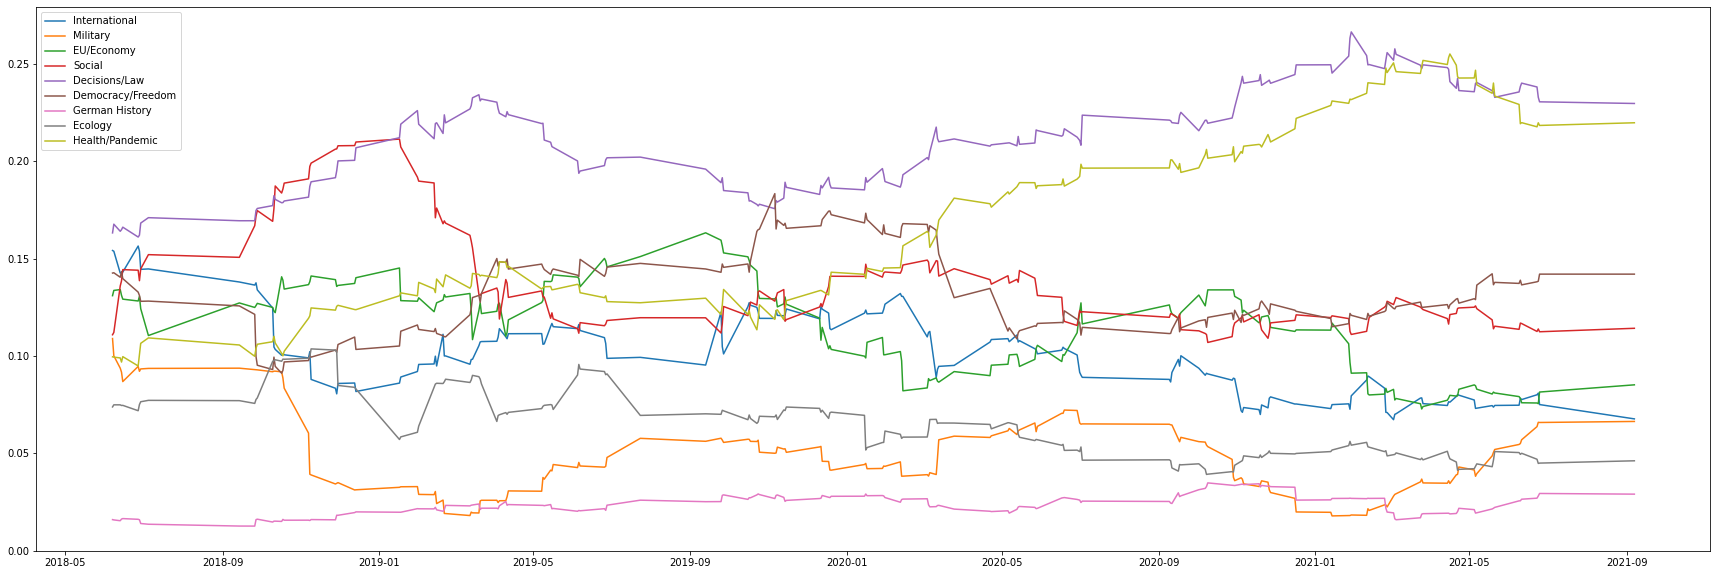

In [15]:
fig, ax = plt.subplots(figsize=(30, 10))

for topic_col in rolling_df.columns:
    ax.plot(rolling_df.index.values, rolling_df[topic_col].values, label=topic_col)
ax.legend()

In [16]:
#plotting commulative stacked area plots
y=[]
topics=[]
for idx, topic_col in enumerate(rolling_df.columns):
    y.append(None)
    topics.append(topic_col)
    y[idx] = rolling_df[topic_col].values
y = np.vstack([y])    

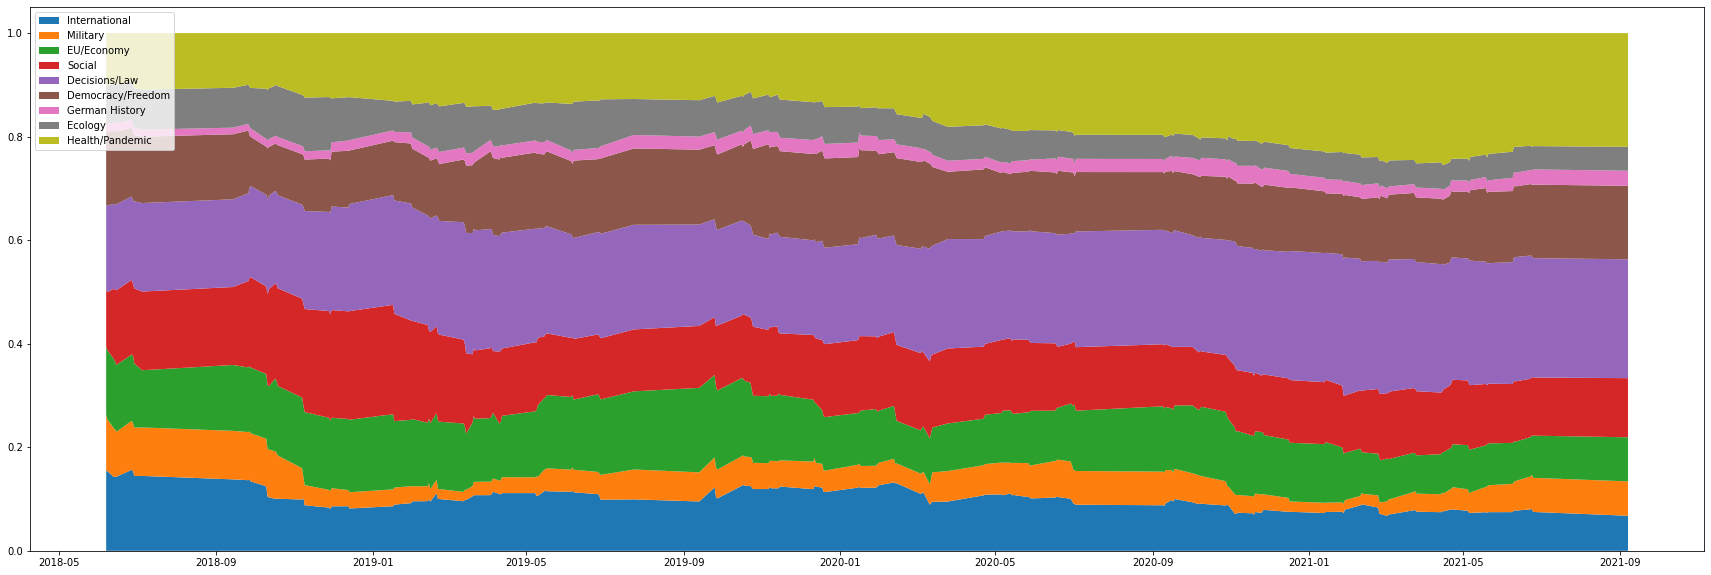

In [17]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.stackplot(rolling_df.index.values, y, labels=topics)
ax.legend(loc='upper left')

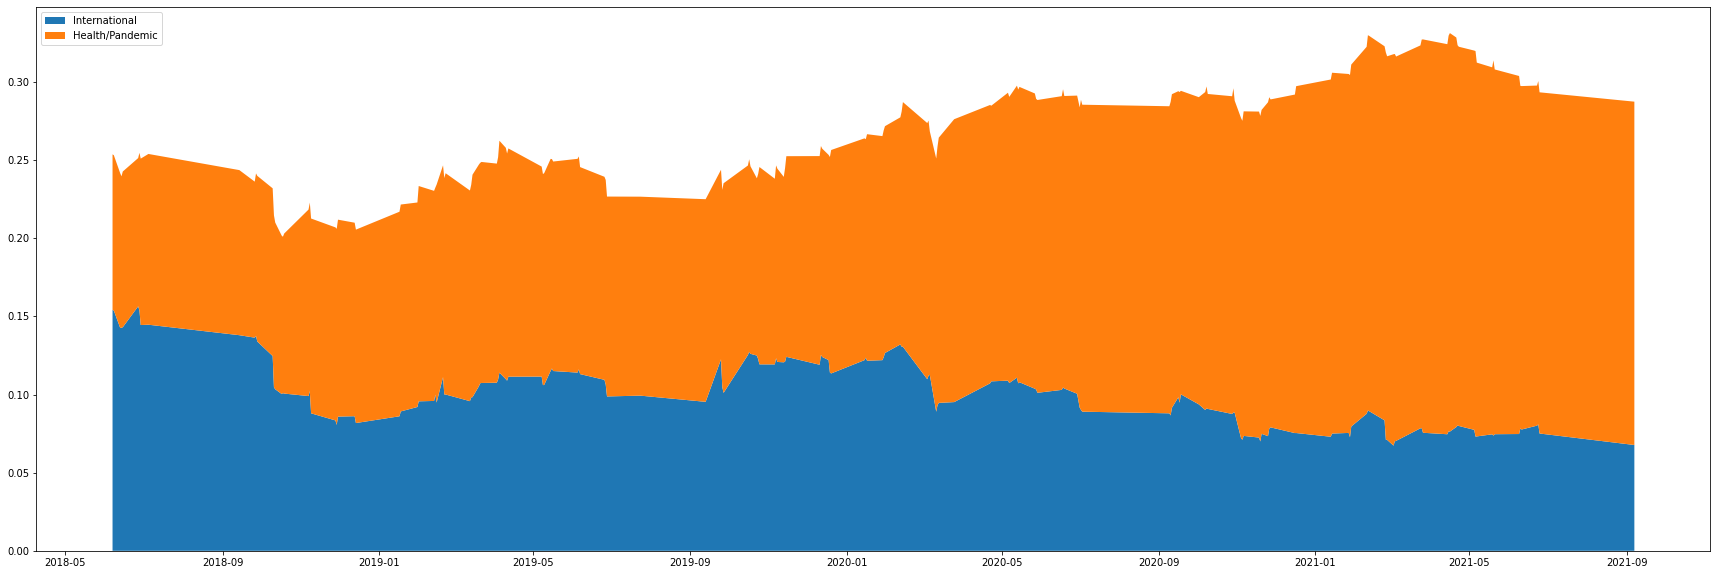

In [18]:
#to plot just a few topics (better to see the behavior of individual topics to each other)
y=[]
topics=[]
topic_cols=['International', 'Health/Pandemic']
        
for idx, topic_col in enumerate(topic_cols):
    y.append(None)
    topics.append(topic_col)
    y[idx] = rolling_df[topic_col].values

y = np.vstack([y])    

fig, ax = plt.subplots(figsize=(30, 10))
ax.stackplot(rolling_df.index.values, y, labels=topics)
ax.legend(loc='upper left')

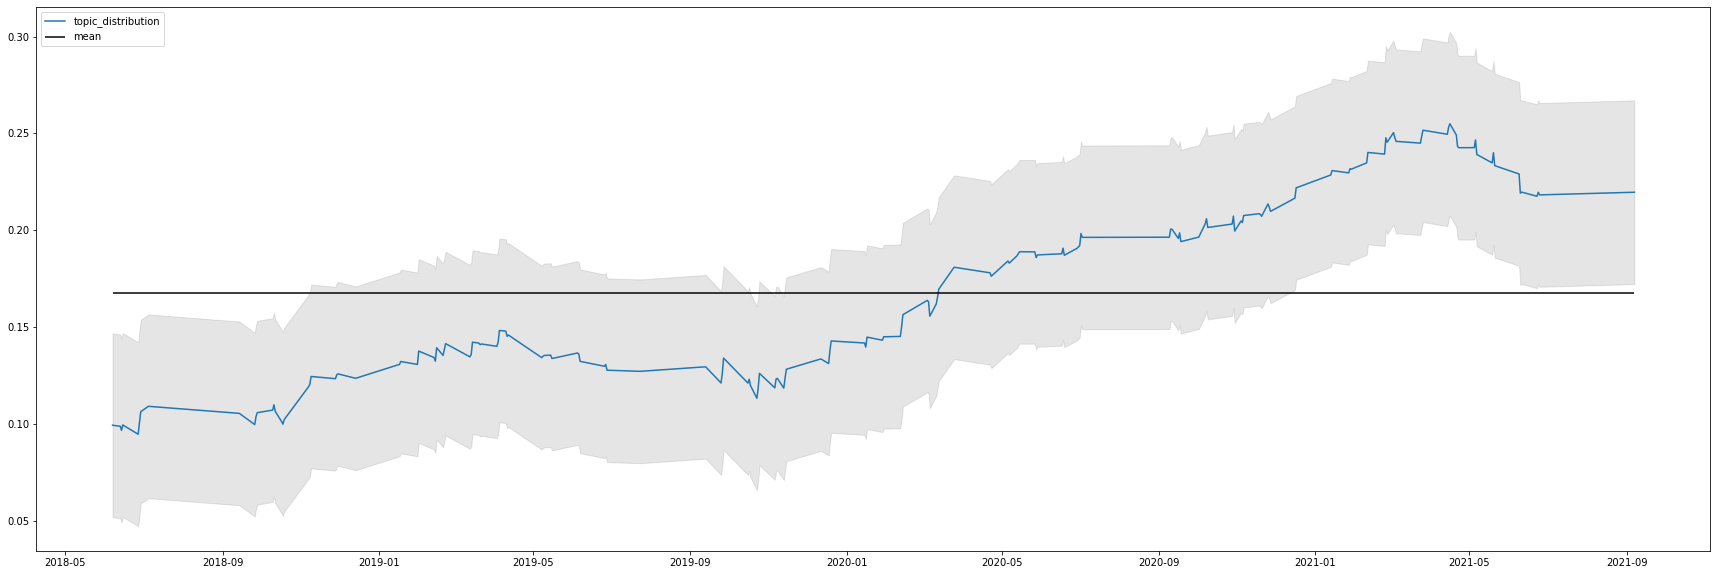

In [19]:
fig, ax = plt.subplots(figsize=(30, 10))
topic= 'Health/Pandemic'


ax.plot(rolling_df.index.values, rolling_df[topic].values, label = 'topic_distribution')

#plot mean and stddev
#mean
ax.hlines(rolling_df[topic].values.mean(), xmin=rolling_df.index.values.min() , xmax = rolling_df.index.values.max(), color='k', label = 'mean')
#stddev - vielleicht mit gaussion process regression?
std = rolling_df[topic].values.std()
ax.fill_between(rolling_df.index.values, rolling_df[topic].values -std, rolling_df[topic].values+std, color='grey', alpha=0.2)

ax.legend(loc='upper left')

## Parties differences

In [20]:
df.groupby('party').mean()

,International,Military,EU/Economy,Social,Decisions/Law,Democracy/Freedom,German History,Ecology,Health/Pandemic
party,,,,,,,,,
AfD,0.085626,0.047221,0.123304,0.102370,0.216955,0.209124,0.018605,0.064128,0.132667
BÜNDNIS 90/DIE GRÜNEN,0.091877,0.056833,0.089866,0.122385,0.221082,0.120718,0.033616,0.062877,0.200746
CDU/CSU,0.086900,0.063361,0.090994,0.120425,0.265963,0.111355,0.017526,0.044452,0.199024
DIE LINKE,0.103902,0.039390,0.103993,0.160943,0.186655,0.144863,0.050982,0.048467,0.160805
FDP,0.084176,0.055731,0.109599,0.132098,0.244666,0.107238,0.028578,0.049948,0.187967
SPD,0.075295,0.048530,0.091382,0.144538,0.238433,0.127872,0.019168,0.047072,0.207711


In [21]:
df.groupby('party').agg(['mean', 'std', 'median'])

C:\Users\emanu\AppData\Local\Temp\ipykernel_10208\2209186754.py:1: FutureWarning: ['date'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby('party').agg(['mean', 'std', 'median'])


International                      Military            \
                               mean       std    median      mean       std   
party                                                                         
AfD                        0.085626  0.180530  0.000713  0.047221  0.142469   
BÜNDNIS 90/DIE GRÜNEN      0.091877  0.189786  0.000783  0.056833  0.163862   
CDU/CSU                    0.086900  0.189990  0.000614  0.063361  0.183514   
DIE LINKE                  0.103902  0.213251  0.000772  0.039390  0.124746   
FDP                        0.084176  0.188767  0.000720  0.055731  0.173156   
SPD                        0.075295  0.177268  0.000658  0.048530  0.161467   

                                EU/Economy                        Social  ...  \
                         median       mean       std    median      mean  ...   
party                                                                     ...   
AfD                    0.000601   0.123304  0.199410  0.009541  0.102370  ...   
BÜNDNIS 90/DIE GRÜNEN  0.000690   0.089866  0.179785  0.000809  0.122385  ...   
CDU/CSU                0.000553   0.090994  0.175063  0.000691  0.120425  ...   
DIE LINKE              0.000678   0.103993  0.186183  0.001020  0.160943  ...   
FDP                    0.000676   0.109599  0.198957  0.000862  0.132098  ...   
SPD                    0.000598   0.091382  0.181926  0.000717  0.144538  ...   

                      Democracy/Freedom German History                      \
                                 median           mean       std    median   
party                                                                        
AfD                            0.127515       0.018605  0.049560  0.000608   
BÜNDNIS 90/DIE GRÜNEN          0.001278       0.033616  0.125222  0.000678   
CDU/CSU                        0.000756       0.017526  0.058806  0.000551   
DIE LINKE                      0.035913       0.050982  0.156674  0.000704   
FDP                            0.000893       0.028578  0.116008  0.000662   
SPD                            0.000950       0.019168  0.069689  0.000601   

                        Ecology                     Health/Pandemic            \
                           mean       std    median            mean       std   
party                                                                           
AfD                    0.064128  0.150438  0.000658        0.132667  0.201188   
BÜNDNIS 90/DIE GRÜNEN  0.062877  0.149119  0.000739        0.200746  0.264458   
CDU/CSU                0.044452  0.123190  0.000582        0.199024  0.252118   
DIE LINKE              0.048467  0.129236  0.000704        0.160805  0.230731   
FDP                    0.049948  0.133467  0.000682        0.187967  0.244917   
SPD                    0.047072  0.130628  0.000629        0.207711  0.253662   

                                 
                         median  
party                            
AfD                    0.002585  
BÜNDNIS 90/DIE GRÜNEN  0.063345  
CDU/CSU                0.080017  
DIE LINKE              0.035947  
FDP                    0.065587  
SPD                    0.096079  

[6 rows x 27 columns]

Text(0.5, 1.0, "PCA of parties' topics")

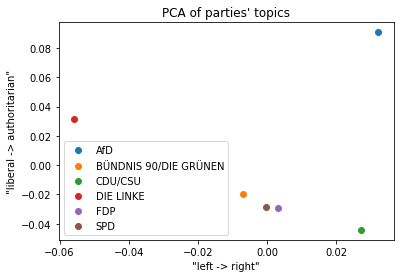

In [22]:
from sklearn.decomposition import PCA

X = df.groupby('party').mean().to_numpy()
pca = PCA(n_components=2)
X_r = pca.fit_transform(X)

fig, ax = plt.subplots()

for party, x_r in zip(df.groupby('party').mean().index, X_r):
    ax.scatter(-x_r[1], x_r[0], label=party,)
ax.legend()
ax.set_xlabel('"left -> right"')
ax.set_ylabel('"liberal -> authoritarian"')
ax.set_title("PCA of parties' topics")

In [23]:
axis0 = [list(columns_mapper.values())[i] for i in np.argsort(np.abs(pca.components_[0]))[::-1]]
axis1= [list(columns_mapper.values())[i] for i in np.argsort(np.abs(pca.components_[1]))[::-1]]

In [24]:
axis0

['Democracy/Freedom',
 'Health/Pandemic',
 'Decisions/Law',
 'EU/Economy',
 'Military',
 'Social',
 'Ecology',
 'International',
 'German History']

In [25]:
axis1

['Decisions/Law',
 'Social',
 'German History',
 'Democracy/Freedom',
 'International',
 'Military',
 'EU/Economy',
 'Ecology',
 'Health/Pandemic']

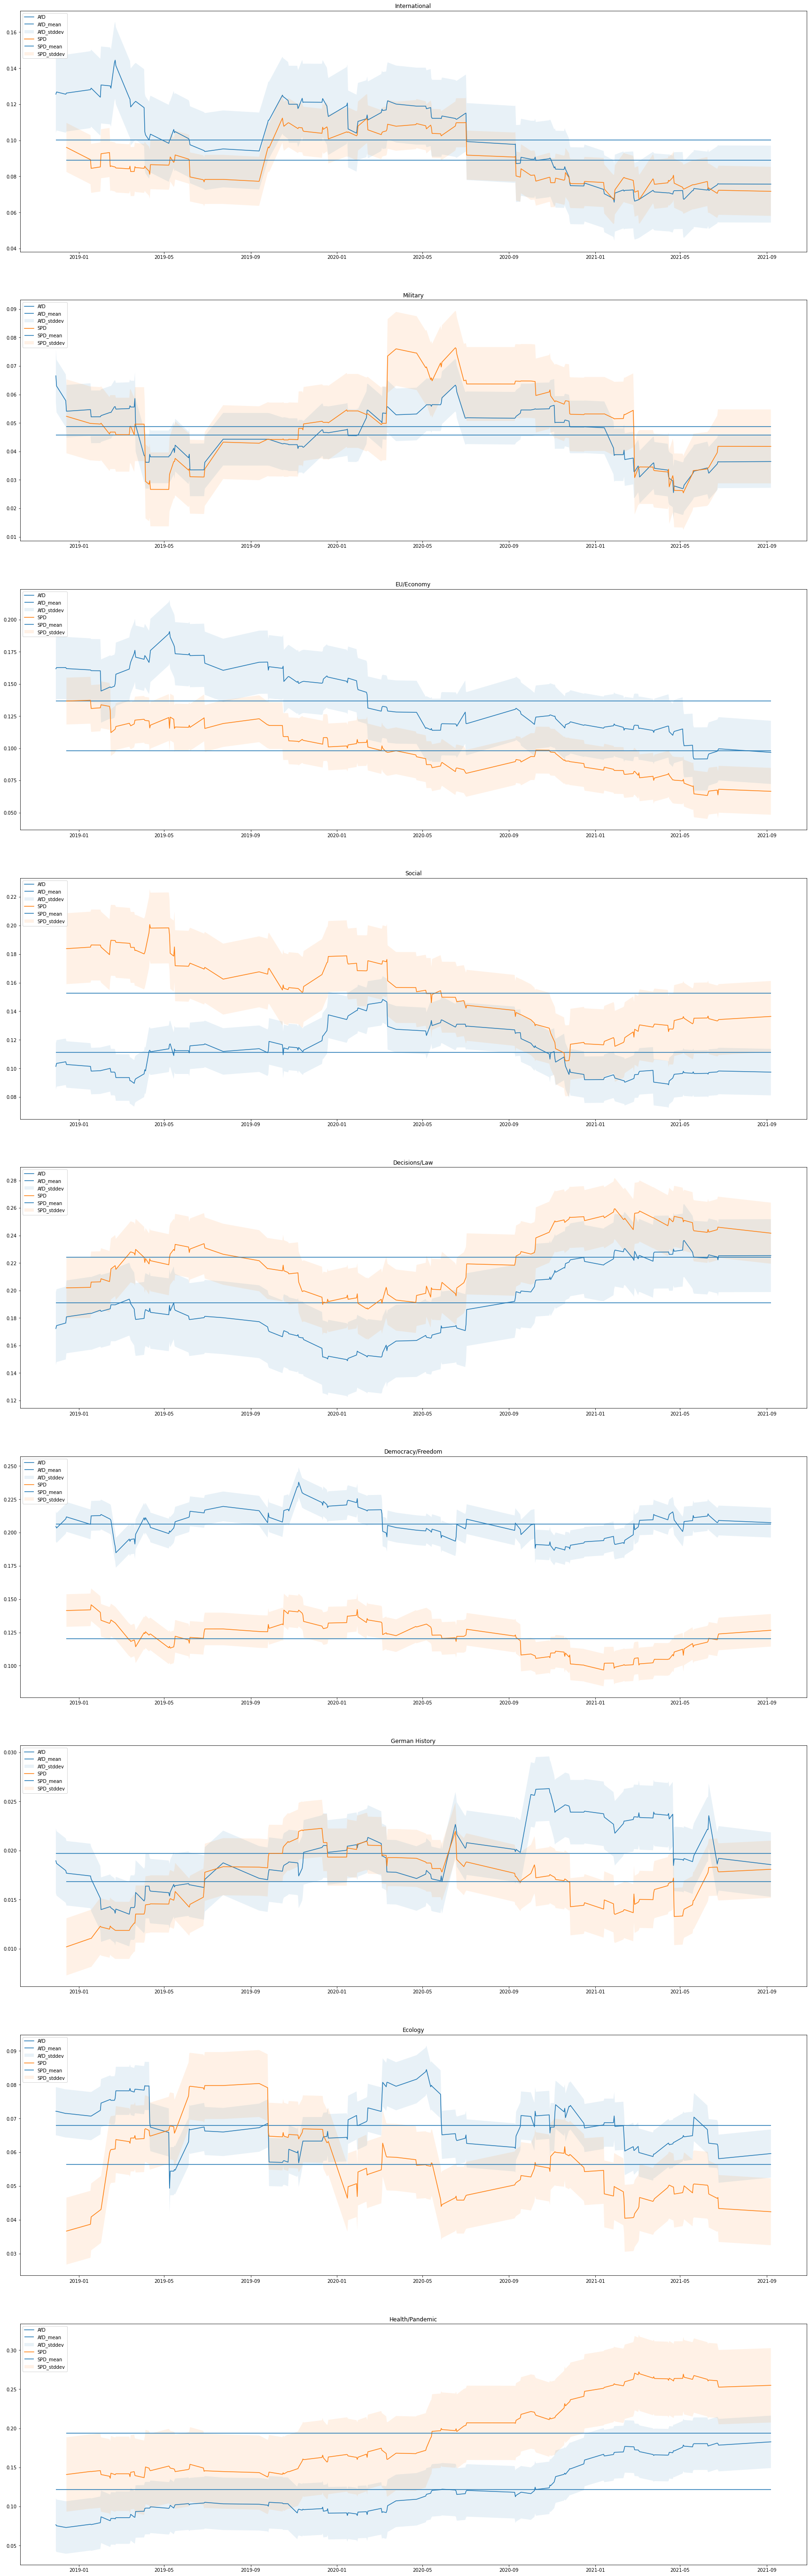

In [34]:
#weiß ned ob hier mean und std sinn macht... kann man ja auch schnell rausnehmen

fig, ax = plt.subplots(9, figsize=(30, 100))
#parties = df['party'].unique()
parties = ['AfD','SPD']

n_days = 50

for topic_col, axis in zip(columns_mapper.values(), ax):
    for party in parties:
        data = df[df['party'] == party]
        axis.plot(
            data['date'].unique()[n_days:],
            data.groupby('date').mean()[topic_col].rolling(n_days).mean().tail(-n_days),
            label=party)
        #mean
        axis.hlines(data.groupby('date').mean()[topic_col].rolling(n_days).mean().tail(-n_days).mean(), xmin=data['date'].unique()[n_days:].min(), xmax=data['date'].unique()[n_days:].max(),label=party+'_mean')
        #stddev
        std=data.groupby('date').mean()[topic_col].rolling(n_days).mean().tail(-n_days).std()
        axis.fill_between(data['date'].unique()[n_days:], data.groupby('date').mean()[topic_col].rolling(n_days).mean().tail(-n_days)-std, data.groupby('date').mean()[topic_col].rolling(n_days).mean().tail(-n_days)+std,alpha=0.1,label=party+'_stddev')
    axis.legend(loc='upper left')
    axis.set_title(topic_col)
    
    
    
    """
ax.hlines(rolling_df[topic].values.mean(), xmin=rolling_df.index.values.min() , xmax = rolling_df.index.values.max(), color='k', label = 'mean')
#stddev - vielleicht mit gaussion process regression?
std = rolling_df[topic].values.std()
ax.fill_between(rolling_df.index.values, rolling_df[topic].values -std, rolling_df[topic].values+std, color='grey', alpha=0.2)
"""